Adopted from this tutorial https://www.kaggle.com/poonaml/text-classification-using-spacy and the official documentation's example https://github.com/explosion/spaCy/blob/master/examples/training/train_textcat.py

## Data preparation

In [3]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
food_reviews_df=pd.read_csv('Reviews.csv')
food_reviews_df.shape

(568454, 10)

In [3]:
food_reviews_df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
ProductId,B001E4KFG0,B00813GRG4,B000LQOCH0,B000UA0QIQ,B006K2ZZ7K
UserId,A3SGXH7AUHU8GW,A1D87F6ZCVE5NK,ABXLMWJIXXAIN,A395BORC6FGVXV,A1UQRSCLF8GW1T
ProfileName,delmartian,dll pa,"Natalia Corres ""Natalia Corres""",Karl,"Michael D. Bigham ""M. Wassir"""
HelpfulnessNumerator,1,0,1,3,0
HelpfulnessDenominator,1,0,1,3,0
Score,5,1,4,2,5
Time,1303862400,1346976000,1219017600,1307923200,1350777600
Summary,Good Quality Dog Food,Not as Advertised,"""Delight"" says it all",Cough Medicine,Great taffy
Text,I have bought several of the Vitality canned d...,Product arrived labeled as Jumbo Salted Peanut...,This is a confection that has been around a fe...,If you are looking for the secret ingredient i...,Great taffy at a great price. There was a wid...


In [4]:
food_reviews_df = food_reviews_df[['Text','Score']].dropna()

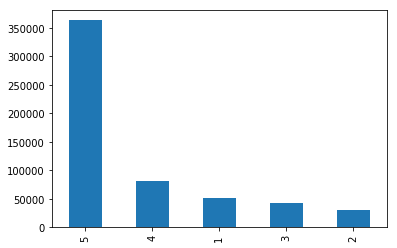

In [5]:
ax=food_reviews_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()

In [6]:
# to deal with the unbalanced data, put ratings 4-5 as positive and ratings 1-3 as negative
food_reviews_df['IsPositive'] = food_reviews_df['Score'] > 3
food_reviews_df.head()

,Text,Score,IsPositive
0,I have bought several of the Vitality canned d...,5,True
1,Product arrived labeled as Jumbo Salted Peanut...,1,False
2,This is a confection that has been around a fe...,4,True
3,If you are looking for the secret ingredient i...,2,False
4,Great taffy at a great price. There was a wid...,5,True


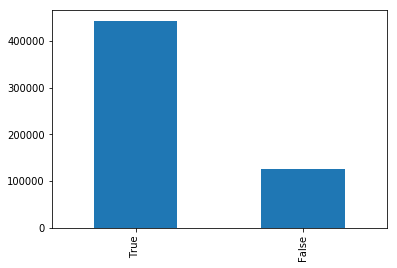

In [7]:
ax=food_reviews_df.IsPositive.value_counts().plot(kind='bar')
fig = ax.get_figure()

Note: this is not a traditional train/test split (that comes later). This is just taking the first 50000 positive reviews and the first 50000 negative reviews so the dataset isn't so huge.

In [8]:
train_pos_df=food_reviews_df[food_reviews_df.IsPositive][:50000]
train_neg_df=food_reviews_df[food_reviews_df.IsPositive != True][:50000]

In [9]:
train_pos_df.head()

,Text,Score,IsPositive
0,I have bought several of the Vitality canned d...,5,True
2,This is a confection that has been around a fe...,4,True
4,Great taffy at a great price. There was a wid...,5,True
5,I got a wild hair for taffy and ordered this f...,4,True
6,This saltwater taffy had great flavors and was...,5,True


In [10]:
train_neg_df.head()

,Text,Score,IsPositive
1,Product arrived labeled as Jumbo Salted Peanut...,1,False
3,If you are looking for the secret ingredient i...,2,False
12,My cats have been happily eating Felidae Plati...,1,False
16,I love eating them and they are good for watch...,2,False
26,"The candy is just red , No flavor . Just plan...",1,False


In [11]:
train_df=train_pos_df.append(train_neg_df)
train_df.shape

(100000, 3)

In [12]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [13]:
sample_review=food_reviews_df.Text[54]
parsed_review = nlp(sample_review)
parsed_review

I roast at home with a stove-top popcorn popper (but I do it outside, of course). These beans (Coffee Bean Direct Green Mexican Altura) seem to be well-suited for this method. The first and second cracks are distinct, and I've roasted the beans from medium to slightly dark with great results every time. The aroma is strong and persistent. The taste is smooth, velvety, yet lively.

## Spacy Text Categorizer

In [14]:
train_df['tuples'] = train_df.apply(
    lambda row: (row['Text'],row['IsPositive']), axis=1)
train = train_df['tuples'].tolist()
train[:1]

[('I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
  True)]

In [15]:
train[-2:]

[("I ordered this product specifically to try out the three different types of products. However, when I received the product, I opened it up only to find three of the Barn Burner salsas - obviously not what I had ordered.<br /><br />Buy at your own risk - who knows what you'll end up getting.",
  False),
 ('Terrific - easy to use and great taste.  Only complaint is that the price is MUCH too high.',
  False)]

In [16]:
import random

The functions in the following cell are inspired both by spacy documentation https://github.com/explosion/spaCy/blob/master/examples/training/train_textcat.py and from the tutorial I've been following https://www.kaggle.com/poonaml/text-classification-using-spacy

In [17]:
def load_data(train_list, limit=0, split=0.8):
    # use random.shuffle if you want to randomize in-place
    train_data = random.sample(train_list, k=len(train_list))
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': y, 'NEGATIVE': not y} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score,
           'textcat_a': accuracy, 'textcat_tp': tp, 'textcat_tn': tn, 'textcat_fp': fp, 'textcat_fn': fn}

#("Number of texts to train from","t" , int)
n_texts=30000
#You can increase texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=10

In [18]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
# use config options from spacy training tutorial
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat', config={"exclusive_classes": True, "architecture": "simple_cnn"})
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier.
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

# load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(train, limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Loading food reviews data...
Using 30000 examples (24000 training, 6000 evaluation)


Training model

In [19]:
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

In [20]:
# get names of other pipes to disable them during training
pipe_exceptions = ["textcat"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F', 'A'))
    # start with a small batch size and then increase? TODO: check that this is what's happening
    batch_sizes = compounding(4.0, 32.0, 1.001)
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print(
                "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(  # print a simple table
                    losses["textcat"],
                    scores["textcat_p"],
                    scores["textcat_r"],
                    scores["textcat_f"],
                    scores["textcat_a"],
                )
            )

Training the model...
LOSS 	  P  	  R  	  F  	  A  
14.481	0.847	0.847	0.847
0.153	0.862	0.862	0.862
0.125	0.868	0.868	0.868
0.107	0.871	0.871	0.871
0.093	0.873	0.873	0.873
0.080	0.874	0.874	0.874
0.070	0.874	0.874	0.874
0.059	0.873	0.873	0.873
0.055	0.872	0.872	0.872
0.047	0.872	0.872	0.872


In [21]:
# test the trained model. Not a full test set, just a quick "does this appear to be working"
test_text1 = 'This tea is fun to watch as the flower expands in the water. Very smooth taste and can be used again and again in the same day. If you love tea, you gotta try these "flowering teas"'
test_text2="I bought this product at a local store, not from this seller.  I usually use Wellness canned food, but thought my cat was bored and wanted something new.  So I picked this up, knowing that Evo is a really good brand (like Wellness).<br /><br />It is one of the most disgusting smelling cat foods I've ever had the displeasure of using.  I was gagging while trying to put it into the bowl.  My cat took one taste and walked away, and chose to eat nothing until I replaced it 12 hours later with some dry food.  I would try another flavor of their food - since I know it's high quality - but I wouldn't buy the duck flavor again."
doc = nlp(test_text1)
test_text1, doc.cats

('This tea is fun to watch as the flower expands in the water. Very smooth taste and can be used again and again in the same day. If you love tea, you gotta try these "flowering teas"',
 {'POSITIVE': 0.9998923540115356, 'NEGATIVE': 0.00010763719183159992})

In [22]:
doc2 = nlp(test_text2)
test_text2, doc2.cats

("I bought this product at a local store, not from this seller.  I usually use Wellness canned food, but thought my cat was bored and wanted something new.  So I picked this up, knowing that Evo is a really good brand (like Wellness).<br /><br />It is one of the most disgusting smelling cat foods I've ever had the displeasure of using.  I was gagging while trying to put it into the bowl.  My cat took one taste and walked away, and chose to eat nothing until I replaced it 12 hours later with some dry food.  I would try another flavor of their food - since I know it's high quality - but I wouldn't buy the duck flavor again.",
 {'POSITIVE': 0.0008882191032171249, 'NEGATIVE': 0.9991117119789124})